## Imports

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

## Fixed Parameters

In [16]:
INPUT_DIM = 1
HIDDEN_DIM = 64
OUTPUT_DIM = 1
TIMESTEPS = 10
PREDICT_AHEAD = 2
TRAIN_RATIO = 0.8
EPOCHS = 100
LEARNING_RATE = 0.01
SEED = 13

In [4]:
np.random.seed(SEED)

## Load & Normalize Dataset

In [6]:
df = pd.read_excel("Stock.xlsx")
df.columns = ['Price']

In [7]:
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(df[['Price']].values)

## Dataset Visualization

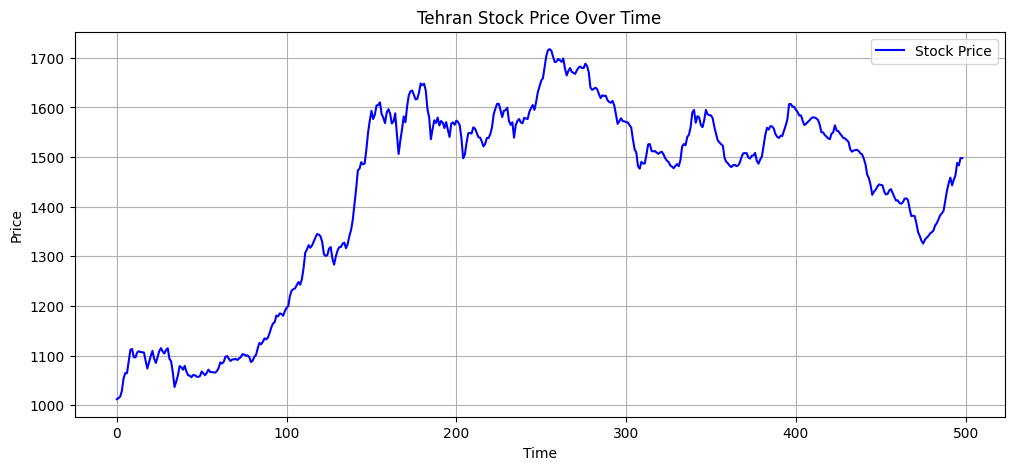

In [19]:
plt.figure(figsize=(12, 5))
plt.plot(df['Price'], label='Stock Price', color='blue')
plt.title("Tehran Stock Price Over Time")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

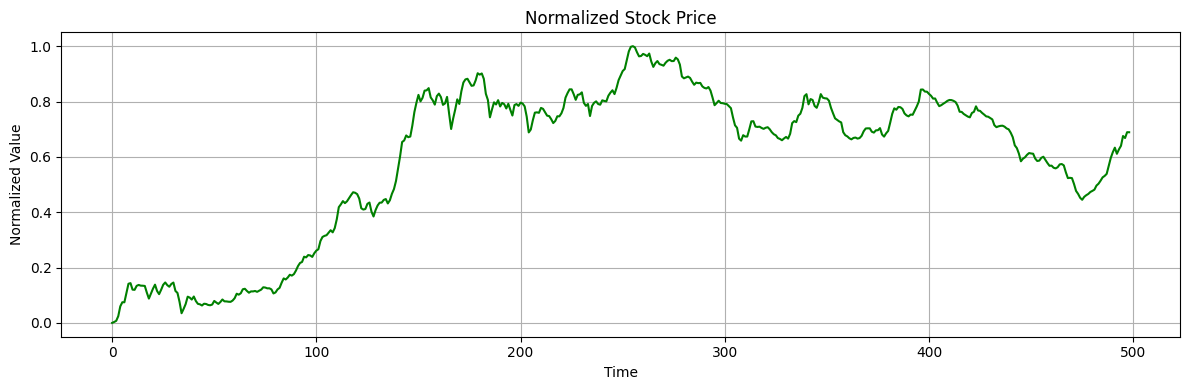

In [20]:
plt.figure(figsize=(12, 4))
plt.plot(normalized_data, color='green')
plt.title("Normalized Stock Price")
plt.xlabel("Time")
plt.ylabel("Normalized Value")
plt.grid(True)
plt.tight_layout()
plt.show()

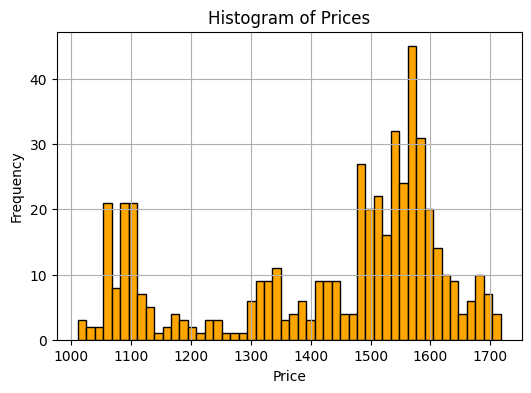

In [21]:
plt.figure(figsize=(6, 4))
plt.hist(df['Price'], bins=50, color='orange', edgecolor='black')
plt.title("Histogram of Prices")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

## Create Sequence 

In [8]:
def create_sequences(data, timesteps=10, predict_ahead=2):
    X, y = [], []
    for i in range(len(data) - timesteps - predict_ahead + 1):
        X.append(data[i:i + timesteps])
        y.append(data[i + timesteps + predict_ahead - 1])
    return np.array(X), np.array(y)

## Base GRU Cell

In [12]:
class GRUCellTrainable:
    def __init__(self, input_dim, hidden_dim):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        def init_weight():
            return np.random.randn(hidden_dim, input_dim + hidden_dim) / np.sqrt(input_dim + hidden_dim)

        self.Wz, self.bz = init_weight(), np.zeros((hidden_dim, 1))
        self.Wr, self.br = init_weight(), np.zeros((hidden_dim, 1))
        self.Wh, self.bh = init_weight(), np.zeros((hidden_dim, 1))

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def forward(self, x_seq):
        h = np.zeros((self.hidden_dim, 1))
        self.cache = []

        for xt in x_seq:
            xt = xt.reshape(-1, 1)
            concat = np.vstack((h, xt))

            z = self.sigmoid(self.Wz @ concat + self.bz)
            r = self.sigmoid(self.Wr @ concat + self.br)

            concat_r = np.vstack((r * h, xt))
            h_tilde = np.tanh(self.Wh @ concat_r + self.bh)
            h_new = (1 - z) * h + z * h_tilde

            self.cache.append({
                'xt': xt,
                'h_prev': h.copy(),
                'z': z,
                'r': r,
                'h_tilde': h_tilde,
                'h': h_new
            })

            h = h_new

        return h

    def zero_grads(self):
        self.dWz = np.zeros_like(self.Wz)
        self.dbz = np.zeros_like(self.bz)
        self.dWr = np.zeros_like(self.Wr)
        self.dbr = np.zeros_like(self.br)
        self.dWh = np.zeros_like(self.Wh)
        self.dbh = np.zeros_like(self.bh)

    def backward(self, dh_next):
        self.zero_grads()

        for t in reversed(range(len(self.cache))):
            cache = self.cache[t]
            xt = cache['xt']
            h_prev = cache['h_prev']
            z = cache['z']
            r = cache['r']
            h_tilde = cache['h_tilde']
            h = cache['h']

            dh = dh_next

            dz = dh * (h_tilde - h_prev)
            dh_tilde = dh * z
            dh_prev = dh * (1 - z)

            dz *= z * (1 - z)
            dh_tilde *= (1 - h_tilde ** 2)

            concat = np.vstack((h_prev, xt))
            concat_r = np.vstack((r * h_prev, xt))

            dr = (self.Wh[:, :self.hidden_dim] @ dh_tilde) * h_prev
            dr *= r * (1 - r)

            self.dWz += dz @ concat.T
            self.dbz += dz
            self.dWr += dr @ concat.T
            self.dbr += dr
            self.dWh += dh_tilde @ concat_r.T
            self.dbh += dh_tilde

            dh_part = (
                self.Wz[:, :self.hidden_dim].T @ dz +
                self.Wr[:, :self.hidden_dim].T @ dr +
                self.Wh[:, :self.hidden_dim].T @ dh_tilde * r
            )
            dh_next = dh_prev + dh_part

    def apply_grads(self, lr=0.01):
        for param, grad in zip(
            [self.Wz, self.bz, self.Wr, self.br, self.Wh, self.bh],
            [self.dWz, self.dbz, self.dWr, self.dbr, self.dWh, self.dbh]
        ):
            param -= lr * grad

## Bidirectional GRU

In [14]:
class BidirectionalGRUTrainable:
    def __init__(self, input_dim, hidden_dim, output_dim):
        self.fw_gru = GRUCellTrainable(input_dim, hidden_dim)
        self.bw_gru = GRUCellTrainable(input_dim, hidden_dim)
        self.W_fc = np.random.randn(output_dim, 2 * hidden_dim) / np.sqrt(2 * hidden_dim)
        self.b_fc = np.zeros((output_dim, 1))

        self.dW_fc = np.zeros_like(self.W_fc)
        self.db_fc = np.zeros_like(self.b_fc)

    def forward(self, x_seq):
        fw_h = self.fw_gru.forward(x_seq)
        bw_h = self.bw_gru.forward(x_seq[::-1])
        self.concat = np.vstack((fw_h, bw_h))
        output = self.W_fc @ self.concat + self.b_fc
        return output.flatten()

    def backward(self, d_output):
        d_output = d_output.reshape(-1, 1)
        self.dW_fc = d_output @ self.concat.T
        self.db_fc = d_output

        d_concat = self.W_fc.T @ d_output
        d_fw = d_concat[:self.fw_gru.hidden_dim, :]
        d_bw = d_concat[self.fw_gru.hidden_dim:, :]

        self.fw_gru.backward(d_fw)
        self.bw_gru.backward(d_bw)

    def apply_grads(self, lr=0.01):
        self.W_fc -= lr * self.dW_fc
        self.b_fc -= lr * self.db_fc
        self.fw_gru.apply_grads(lr)
        self.bw_gru.apply_grads(lr)

## Train

In [15]:
def train_bptt_gru(model, X_train, y_train, X_test, y_test, epochs=10, lr=0.01):
    train_losses, test_losses = [], []

    for epoch in range(epochs):
        train_loss = 0
        for i in range(len(X_train)):
            y_pred = model.forward(X_train[i])
            loss = np.mean((y_pred - y_train[i]) ** 2)
            train_loss += loss

            d_loss = 2 * (y_pred - y_train[i])
            model.backward(d_loss)
            model.apply_grads(lr)

        train_losses.append(train_loss / len(X_train))

        test_loss = 0
        for i in range(len(X_test)):
            y_pred = model.forward(X_test[i])
            test_loss += np.mean((y_pred - y_test[i]) ** 2)

        test_losses.append(test_loss / len(X_test))
        print(f"Epoch {epoch+1}: Train MSE = {train_losses[-1]:.6f}, Test MSE = {test_losses[-1]:.6f}")

    return train_losses, test_losses

## Main

### Create sequence

In [9]:
X, y = create_sequences(normalized_data, TIMESTEPS, PREDICT_AHEAD)

### Split data

In [10]:
split_index = int(TRAIN_RATIO * len(X))
X_train, y_train = X[:split_index], y[:split_index]
X_test, y_test = X[split_index:], y[split_index:]

### Run

In [17]:
model_gru = BidirectionalGRUTrainable(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM)
train_loss_gru, test_loss_gru = train_bptt_gru(model_gru, X_train, y_train, X_test, y_test,
                                               epochs=EPOCHS, lr=LEARNING_RATE)

Epoch 1: Train MSE = 0.002940, Test MSE = 0.011845
Epoch 2: Train MSE = 0.005073, Test MSE = 0.009248
Epoch 3: Train MSE = 0.003755, Test MSE = 0.007577
Epoch 4: Train MSE = 0.002950, Test MSE = 0.006480
Epoch 5: Train MSE = 0.002456, Test MSE = 0.005746
Epoch 6: Train MSE = 0.002149, Test MSE = 0.005244
Epoch 7: Train MSE = 0.001953, Test MSE = 0.004893
Epoch 8: Train MSE = 0.001825, Test MSE = 0.004640
Epoch 9: Train MSE = 0.001738, Test MSE = 0.004454
Epoch 10: Train MSE = 0.001678, Test MSE = 0.004313
Epoch 11: Train MSE = 0.001634, Test MSE = 0.004203
Epoch 12: Train MSE = 0.001601, Test MSE = 0.004115
Epoch 13: Train MSE = 0.001575, Test MSE = 0.004042
Epoch 14: Train MSE = 0.001555, Test MSE = 0.003980
Epoch 15: Train MSE = 0.001538, Test MSE = 0.003926
Epoch 16: Train MSE = 0.001523, Test MSE = 0.003878
Epoch 17: Train MSE = 0.001511, Test MSE = 0.003835
Epoch 18: Train MSE = 0.001499, Test MSE = 0.003794
Epoch 19: Train MSE = 0.001489, Test MSE = 0.003756
Epoch 20: Train MSE =

## Result

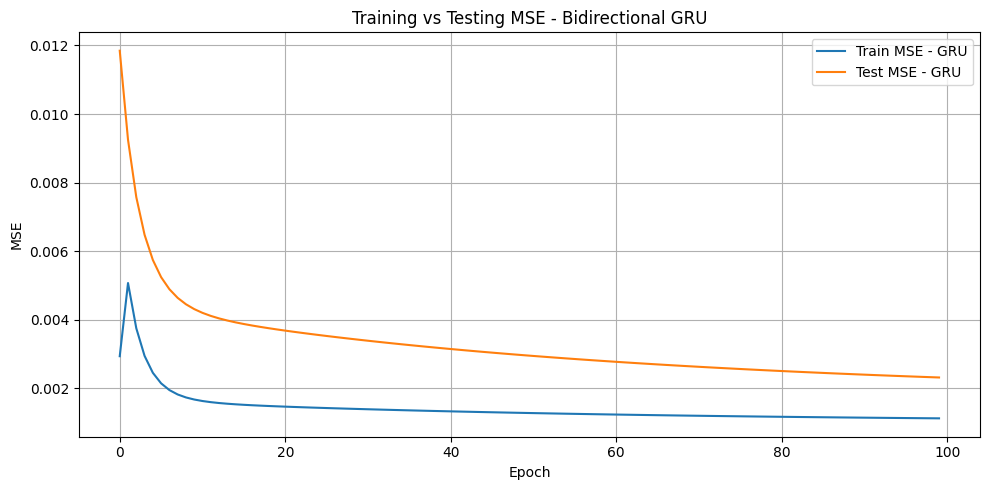

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(train_loss_gru, label="Train MSE - GRU")
plt.plot(test_loss_gru, label="Test MSE - GRU")
plt.title("Training vs Testing MSE - Bidirectional GRU")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()